# Projections between subdomains and interfaces

In this tutorial, we illustrate the use of the projection operators that
exist in PorePy. The projection of quantities is done between a pair of subdomains that
are one dimension apart, such as a rock and a fracture. The transfer is
done using specific projections to and from the interface between them, where
the type of projection method used depends on the type of quantities involved. 

The two types of quantities we consider are extensive and
intensive quantities:
- Extensive quantities depend on the size or amount of the system. Examples include
fluxes, mass and energy. If you divide the system in half, these quantities are
also halved.
- Intensive quantities are independent of the size or amount of the system. Examples
include temperature, pressure and density. These remain the same whether you look at the
whole system or just part of it.

We will provide examples of projections for both types of quantities.

## Terminology and concept
Consider a fractured domain, like that shown in the left diagram below, which is
represented by a mixed-dimensional geometry. Quantities are projected between the
fracture (lower-dimensional subdomain, colored in black) and the rock (higher-dimensional subdomain, colored in light grey) through an interface (right diagram,
dashed blue).

There are in total two grids neighboring an interface, and they are often referred to as
primary or secondary grids. Typically, the secondary grid is of the same dimension as
the interface, while the primary grid is of one dimension higher.

<img src='img/schematic_mdg_incl_interface.png'  width=900>

Projecting an arbitrary quantity $\gamma$ from the higher-dimensional subdomain (primary
grid, $\Omega_h$) to the lower-dimensional subdomain (secondary grid, $\Omega_l$) is
done via the interface, $\Gamma$. The projection therefore happens in
two-steps: first from the primary grid to the interface and then from the interface to
the secondary grid. 

Mathematically, the process is described as follows: $$ \Omega_h\overset{\Pi_{j}^h
\gamma}{\longrightarrow} \Gamma_j\overset{{\Xi}_{l}^j (\beta)}{\longrightarrow}
\Omega_l, $$ where $$\beta = \Pi_{h}^j(\gamma).$$ Here $\Pi_{j}^h$ is the projection map
from $\Omega_h$ to $\Gamma_j,$ and $\Xi_{l}^j$ is the projection map from $\Gamma_j$ to
$\Omega_l$. Projections from the fracture to the matrix are defined analogously.

# Demonstration of projections
We will use a simulation example to demonstrate the workings of the projections of both
intensive and extensive quantities for a non-matching grid. A non-matching grid is
chosen such that it is possible to see the difference between the projection of
intensive and extensive quantities. Note that for matching grids, all projections 
are from exactly one face or cell to exactly one face or cell, and much of the below
simplifies significantly.

## Creation of non-matching mixed-dimensional geometry
The model class we will use for the following projection examples is based
on the single phase flow model found within PorePy. The modifications we are going to
make are to add non-trivial boundary conditions and setting a fractured geometry. 

To make the mixed-dimensional grid non-matching, we will modify the method
`set_geometry`. This is simply done by creating a tentative mixed-dimensional grid,
defining a new fracture subdomain by refining the old one, and then using the method
`replace_subdomains_and_interfaces` to update the mixed-dimensional geometry. In the
case demonstrated below, the fracture grid is refined by a ratio of 2, i.e., each
fracture cell is divided in two. 

In [10]:
import porepy as pp
import numpy as np


class GeometryAndBC:
    """Mixin for defining the model geometry and boundary conditions."""

    def set_geometry(self) -> None:
        """Define geometry and create a non-matching mixed-dimensional grid."""
        super().set_geometry()

        # Refine fracture grid such that the mixed-dimensional geometry is non-matching.
        old_fracture_grid = self.mdg.subdomains(dim=1)[0]
        new_fracture_grid = pp.refinement.refine_grid_1d(g=old_fracture_grid, ratio=2)
        self.mdg.replace_subdomains_and_interfaces(
            {old_fracture_grid: new_fracture_grid}
        )

        # Create projections between local and global coordinates for fracture grids.
        pp.set_local_coordinate_projections(self.mdg)

    def set_domain(self) -> None:
        """Defining a two-dimensional rectangular domain."""
        size = self.units.convert_units(1.0, "m")
        box: dict[str, pp.number] = {"xmax": size, "ymax": 2.0 * size}
        self._domain = pp.Domain(box)

    def meshing_arguments(self) -> dict[str, float]:
        """Set the meshing arguments."""
        return self.params.get("meshing_arguments", {"cell_size": 0.5})

    def set_fractures(self) -> None:
        """Set a vertical fracture."""
        frac_1_points = self.units.convert_units(
            np.array([[0.5, 0.5], [0.5, 1.5]]), "m"
        )
        frac_1 = pp.LineFracture(frac_1_points)
        self._fractures = [frac_1]

    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign Dirichlet to the west and east boundaries.

        Parameters:
            sd: The subdomain grid.

        Returns:
            The boundary condition with Dirichlet on the west and east boundaries.

        """
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Assign pressure boundary values for projection tutorial.

        We assign some non-trivial pressure boundary condition values for demonstrating
        the projection of quantities between the rock matrix, mortar grids and fracture.

        Parameters:
            boundary_grid: The boundary grid.

        Returns:
            The pressure values at the boundary.

        """
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)

        y = boundary_grid.cell_centers[1, :][bounds.west]
        values[bounds.west] = self.units.convert_units(42 * y, "Pa")
        values[bounds.east] = self.units.convert_units(24, "Pa")
        return values

We then combine the mixin for the geometry and boundary conditions with the single phase
flow model class. Subsequently we run the simulation: 

In [11]:
class SinglePhaseFlowNonMatchingGrid(GeometryAndBC, pp.SinglePhaseFlow):
    """Single phase flow in a fractured domain represented by non-matching grids."""

model = SinglePhaseFlowNonMatchingGrid()
pp.run_time_dependent_model(model)

We plot the mixed-dimensional grid to visualize the location of the fracture and we plot
the fracture grid to visualize that the mixed-dimensional grid is non-matching.
In the plot which visualizes the fracture only, fracture cells are indicated in red
circles while fracture faces are indicated by yellow diamonds.

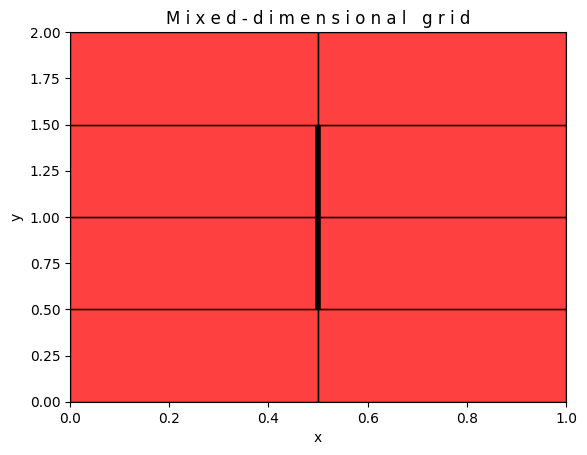

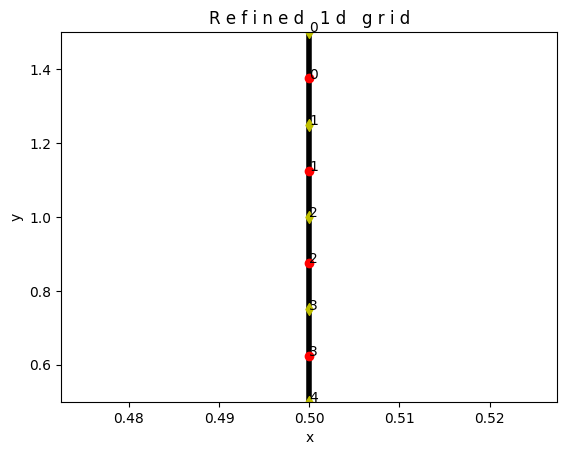

In [12]:
pp.plot_grid(model.mdg, fracturewidth_1d=4, plot_2d=True, alpha=0.75)
pp.plot_grid(
    model.mdg.subdomains(dim=1)[0],
    fracturewidth_1d=4,
    plot_2d=True,
    info="cf")

We see in the 2D plot that the fracture (indicated by a bold, black, vertical line) is
neighboring two higher-dimensional grid cells on each side. However, as shown in the
second plot, the fracture itself has four cells. This means that for each face of the
higher-dimensional grid which neighbors the fracture, there are two fracture cells.

Specifically, we have the following grid-relations (not visible from the plots, but
available through inspection) which we will use later:
* Fracture cells are numbered 0, 1, 2, 3.
* Fracture cells 0 and 1 are neighbors of face 7 and 23 of the matrix.
* Fracture cells 2 and 3 are neighbors of face 4 and 22 of the matrix.

Additionally we will mention that the cells of the mortar grid match the faces of the
matrix. That is, we have a mortar grid with 4 cells (two on each side of the fracture).

We now fetch the subdomains and interfaces, and then instantiate the mortar projections.
These will be used in the following sections which demonstrate the projections by
examples.

In [13]:
mdg_interfaces = model.mdg.interfaces(codim=1)
subdomains = model.interfaces_to_subdomains(mdg_interfaces)
projection = pp.ad.MortarProjections(model.mdg, subdomains, mdg_interfaces, dim=1)

## Projection of intensive quantities
We will here demonstrate projection of pressure, which is an intensive quantity. The
projection of pressure will be examplified in two ways:
* Projection from the rock matrix to the fracture.
* Projection from the fracture to the interface. 

Note that projecting pressure from the higher dimensional subdomain requires us to first
take the trace of the pressure. This is because the pressure is a cell quantity and the
projection requires a face quantity. 

Within PorePy, the projections are done by projection methods found in the
MortarProjections class. The projections intended for intensive quantities have names
ending with `_avg`, where `_avg` is short for "average":
- `mortar_to_primary_avg()`
- `mortar_to_secondary_avg()`
- `primary_to_mortar_avg()`
- `secondary_to_mortar_avg()`

In the figure below, we see a set of non-matching cells with areas $A_1$, $A_2$ and $A$.
Projecting pressure from two cells onto one cell involves calculating the pressure in
the target cell as a weighted average. This averaging process is weighted based on the
areas of the cells, meaning the pressures $p_1$ and $p_2$ are combined, each scaled
according to its cell area relative to the area of the target cell. Note that in the
case of $A_1 = A_2$, the computed value is just the average of $p_1$ and $p_2$.

<img src='img/projection_of_intensive_quantities.png'  width=900>

The first example we will show is the projection of pressure from a higher dimensional
subdomain to a fracture. The projection can be divided into two steps: First we project
the (traced) pressure from the matrix to the mortar grid and then we project from the
mortar grid to the fracture. 

In [14]:
# Projection of traced pressure from the higher-dimensional subdomain (rock) to the interface.
matrix_pressure_at_interface = projection.primary_to_mortar_avg() @ model.pressure_trace(subdomains)

# Projection of the pressure on the interface to the lower-dimensional subdomain (fracture).
matrix_pressure_in_fracture = projection.mortar_to_secondary_avg() @ matrix_pressure_at_interface

The resulting quantity, `pressure_from_intf`, is constructed by projected values from
both sides of the mortar grid. Note that the pressure contributions from each side are
summed together, which does not necessarily make much physical sense. The resulting
projected values are:

In [15]:
print(
    "Projection using MortarProjection:",
    model.equation_system.evaluate(matrix_pressure_in_fracture)[-4:]
)

Projection using MortarProjection: [73.5915493 73.5915493 58.4084507 58.4084507]


We will now compute the same projection by hard-coded indices instead
of the MortarProjection class:

In [16]:
pressure_trace = model.equation_system.evaluate(model.pressure_trace(subdomains))

# Traced pressures neighboring fracture cells 0 and 1:
print("Projection using hard-coded indices:", pressure_trace[7] + pressure_trace[23])

# Traced pressures neighboring fracture cells 2 and 3:
print("Projection using hard-coded indices:", pressure_trace[4] + pressure_trace[22])

Projection using hard-coded indices: 73.59154929577466
Projection using hard-coded indices: 58.40845070422535


In the next example we will project pressure values from the fracture onto the
mortar grid. As we have refined only the fracture, and not the matrix or the mortar
grid, we are projecting _from_ two cells _to_ one cell. The resulting quantity in the
target cell is going to be the average of the values in the cells we are projecting
from:

In [17]:
# Pressure values projected from the fracture onto the mortar grid:
fracture_pressure_on_intf = projection.secondary_to_mortar_avg() @ model.pressure(subdomains)
fracture_pressure_on_intf_value = model.equation_system.evaluate(fracture_pressure_on_intf)
print("Projection using MortarProjection:", fracture_pressure_on_intf_value)

# Pressure values in the fracture:
fracture_pressure_values = model.equation_system.evaluate(model.pressure(subdomains))[-4:]

# Average fracture pressure values:
average_01 = (fracture_pressure_values[0] + fracture_pressure_values[1])/2
average_23 = (fracture_pressure_values[2] + fracture_pressure_values[3])/2

print("Projection from fracture cells 0 and 1 using hard-coded indices:", average_01)
print("Projection from fracture cells 2 and 3 using hard-coded indices:", average_23)

Projection using MortarProjection: [36.6971831 29.3028169 36.6971831 29.3028169]
Projection from fracture cells 0 and 1 using hard-coded indices: 36.69718309859155
Projection from fracture cells 2 and 3 using hard-coded indices: 29.30281690140845


We see in this example that the pressure projected onto the mortar grid cells 1 and 3 (top left and top right interface cell) equals the average of the pressure in fracture cells 0 and 1 (two topmost fracture cells).

## Projection of extensive quantities
We will here demonstrate projection of the Darcy flux, which is integrated over face
areas and hence an extensive quantity. Specifically, we will demonstrate the projection
of the flux from the higher-dimensional subdomain to the fracture. The resulting
projected quantity represents the sum of normal fluxes into the fracture. Within PorePy,
extensive quantities are projected by use of projection methods that have a name ending
with `_int`:
- `primary_to_mortar_int()`
- `secondary_to_mortar_int()`
- `mortar_to_primary_int()`
- `mortar_to_secondary_int()`

Similar to the explanation above, where pressure (an intensive quantity) is projected
from two cells onto one, we here consider the process of an extensive quantity being
projected from one cell onto two. In the figure below we see a set of non-matching cells
with areas $A_{1}$, $A_{2}$ and $A$. Projecting from one cell to two cells means that
the flux is split between the target cells, where the amount of flux per cell is
determined by the relative target cell area (compared to that of the original cell).

<img src='img/projection_of_extensive_quantities.png'  width=900>

In the example we are about to show, values are projected to the fracture from two
sides. This means that the flux values in the fracture will be the sum of the fluxes
from each mortar side. As the values are projected between non-matching grids, the
values are also distributed (in a weighted manner) to all the target fracture cells.

In [18]:
# For demonstrating how the projection works we will fetch the Darcy flux values in the
# matrix:
darcy_flux_value = model.equation_system.evaluate(model.darcy_flux(subdomains))

# The projection of Darcy flux values to the fracture:
flux_on_intf = projection.primary_to_mortar_int() @ model.darcy_flux(subdomains)
flux_in_fracture = projection.mortar_to_secondary_int() @ flux_on_intf
flux_in_fracture_value = model.equation_system.evaluate(flux_in_fracture)[-4:]

print("Fluxes projected using MortarProjection:", flux_in_fracture_value)

# Sum of fluxes from each side of the fracture, and then divided by two as there are two
# fracture cells of equal size:
fracture_flux_01 = (darcy_flux_value[23] + darcy_flux_value[7]) / 2
fracture_flux_23 = (darcy_flux_value[22] + darcy_flux_value[4]) / 2

print("Fluxes projected by hard-coded indices:", fracture_flux_01, fracture_flux_23)

Fluxes projected using MortarProjection: [12.3895984  12.3895984   3.72980459  3.72980459]
Fluxes projected by hard-coded indices: 12.389598399753808 3.7298045853208173


We see that the projected values resulting from using MortarProjection (first print) are
equal to the projection using hard-coded indices (second print).

# What we have explored
We have demonstrated the projections used to transfer values between subdomains through an interface. We considered several examples of
projections between non-matching grids of both extensive and intensive quantities.